<a href="https://colab.research.google.com/github/Carlos99888/ml_project_stockmarket/blob/main/main_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install backtesting

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 3.6 MB/s eta 0:00:00


In [3]:
pip install polygon-api-client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.9 MB/s eta 0:00:00


In [4]:
pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 44.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 13.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: pandas
    Found existing insta

In [56]:
from polygon import RESTClient
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA

import pandas as pd
import pandas_ta as ta
import numpy as np
import time
from datetime import datetime
from scipy.stats import norm
import csv
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

Instantiating the RESTful client api and passing the API key (You can get your API key from polygonIO by creating an account)

In [2]:
api_k = "YOUR API KEY"
client = RESTClient(api_k)

Defining a function to get the historical data for SPY, starting date to ending date

In [3]:
def get_spy_historical(start_date, end_date):


        rows = []

        for bar in client.list_aggs(
            ticker="SPY",
            multiplier=1,
            timespan="day",
            from_=start_date,
            to=end_date,
            adjusted=True,
            sort="asc",
            limit=50000
        ):
            # Convert timestamp
            ts = int(bar.timestamp)
            ts_sec = ts / 1000
            date = datetime.utcfromtimestamp(ts_sec).strftime("%Y-%m-%d")

            rows.append({
                "date": date,
                "open": bar.open,
                "high": bar.high,
                "low": bar.low,
                "close": bar.close,
                "volume": bar.volume
            })

        df = pd.DataFrame(rows)
        return df

Defining a function that applies technical indicators to the historical data of SPY.

Technical indicators are mathematical functions that uses price and volume to find trends in the market. Indicators used in this are:
- EMA (Exponential Moving Average): used for finding trends in the market that uses most recent prices.
- RSI (Relative Strenght Index): is momentum oscillator (oscillates 0-100) and its used for indicating when a stock is overbought or oversold. When is above 70 typically indicates is overbought and below 30 is oversold.
- Bollinger Bands: it measures market volatility. Helps identify high and low price level to spot a potential trend continuation or reversal.
- OBV (On-Balance Volume): relates an asset price and volume to measure buying and selling pressure. This can be used to confirm price trends or reversal (much like bollinger bands).
- CMF (Chaikin Money Flow): volume-weighted indicator to measure buying and selling pressure over specific period. It oscillates, positive values indicate buying pressure and negative is selling pressure.

In [4]:
def add_indicators(df):
        df.rename(columns={
            "date": "Date", "open": "Open", "high": "High",
            "low": "Low", "close": "Close", "volume": "Volume"
        }, inplace=True)
        df["Date"] = pd.to_datetime(df["Date"])
        df.set_index("Date", inplace=True)

        # Trend
        df["EMA_20"] = ta.ema(df["Close"], length=20)
        df["EMA_50"] = ta.ema(df["Close"], length=50)
        df["EMA_200"] = ta.ema(df["Close"], length=200)
        # Momentum
        df["RSI_14"] = ta.rsi(df["Close"], length=14)
        df = pd.concat([df, ta.macd(df["Close"])], axis=1)
        # Volatility
        df = pd.concat([df, ta.bbands(df["Close"])], axis=1)
        # Volume
        df["OBV"] = ta.obv(df["Close"], df["Volume"])
        df["CMF"] = ta.cmf(df["High"], df["Low"], df["Close"], df["Volume"])
        # Returns & Volatility
        df["return_1d"] = df["Close"].pct_change()
        df["return_5d"] = df["Close"].pct_change(5)
        df["volatility_20d"] = df["return_1d"].rolling(20).std()
        df = df.fillna(method="bfill").fillna(method="ffill")
        return df

Getting the historical data for SPY from starting date to end date. Apply the indicators to the dataset and saving it as a csv file. We will use this as our training data (if you are using Google Colab, this should be saved in your content folder).

In [23]:
spy_df = get_spy_historical("2025-01-01", "2025-11-13")
spy_df_indicator = add_indicators(spy_df)
spy_df_indicator.to_csv("spy_hist_indicator.csv")

/tmp/ipython-input-2394281317.py:19: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  date = datetime.utcfromtimestamp(ts_sec).strftime("%Y-%m-%d")
/tmp/ipython-input-3233232610.py:25: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="bfill").fillna(method="ffill")


The first model we are testing is the Regression Model. Below we are loading the csv file and creating a new column "predict_next_close" which is going to be the next day closing price.

In [28]:
df = pd.read_csv("spy_hist_indicator.csv")
col_name = df.columns
col_name = col_name.drop(["Date","High", "Low"]) #droping the date, high, and low as they are not need when using the indicators
df["predict_next_close"] = df["Close"].shift(-1)
df = df.dropna()

X = df[col_name]
y = df["predict_next_close"]

#train split, using 80% (170 rows) for training and 20% (43 rows) for testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=False)

#train model
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)

LinearRegression()

Below are the graph for RSME and MAE (created by the code below). The train RSME got a score of 6.22 and the MAE 4.42. This means on average the model was off by 6.22 and 4.42, in closing price. Additionally the model predicted the next day close price to be 679.93 and the actual value 671.93 for 2025-11-12. Even though the prediction is off from what the RSME and MAE suggested, but that just shows that linear regression has it limits when trying to predict something so complex like the stock market, which is often not so linear.

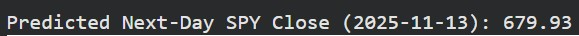

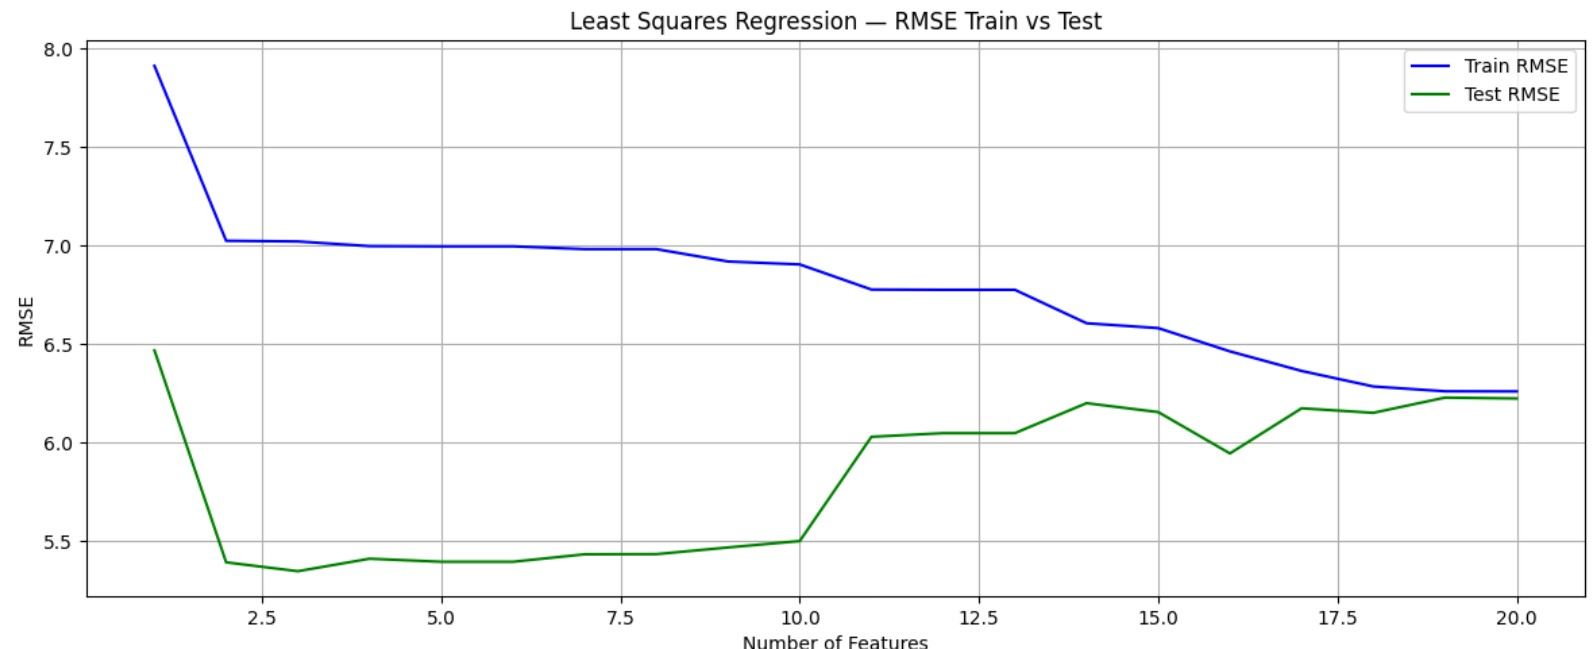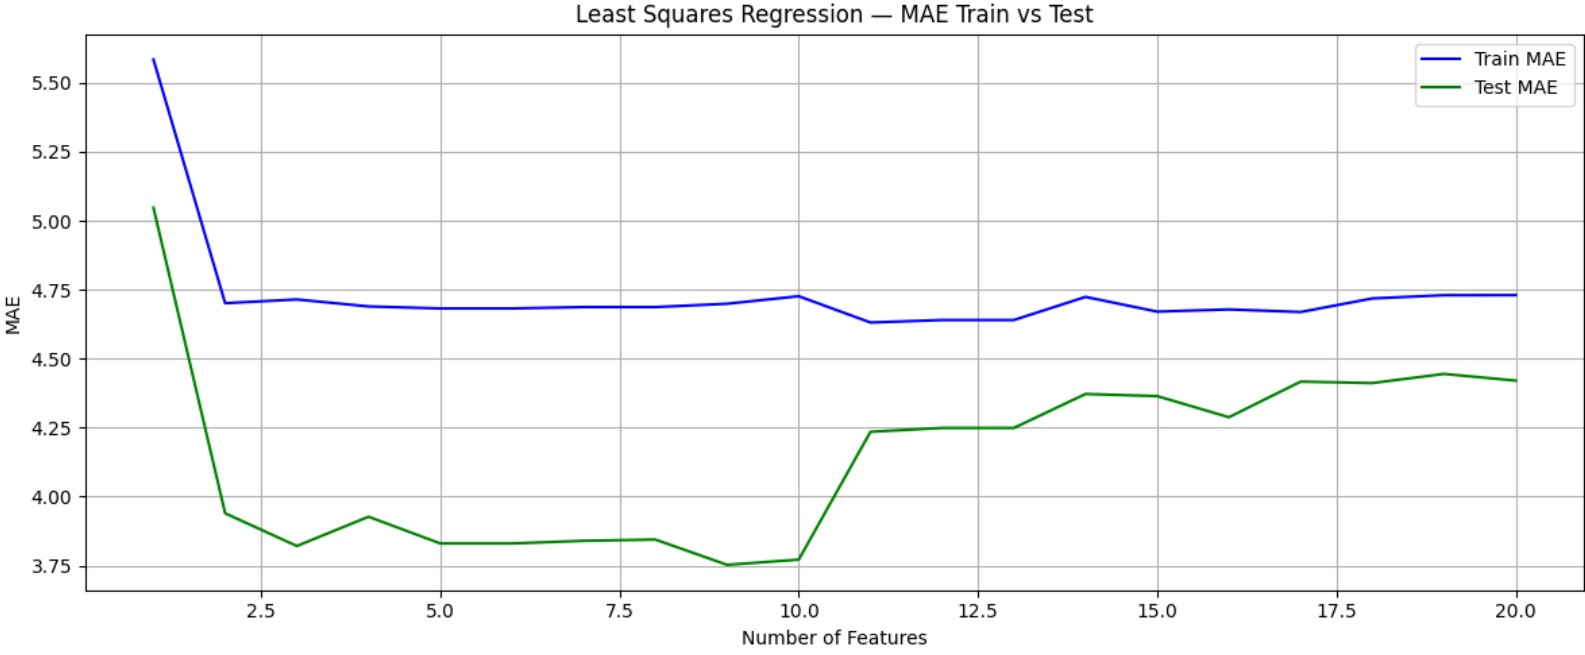



Predicted Next-Day SPY Close (2025-11-13): 679.93


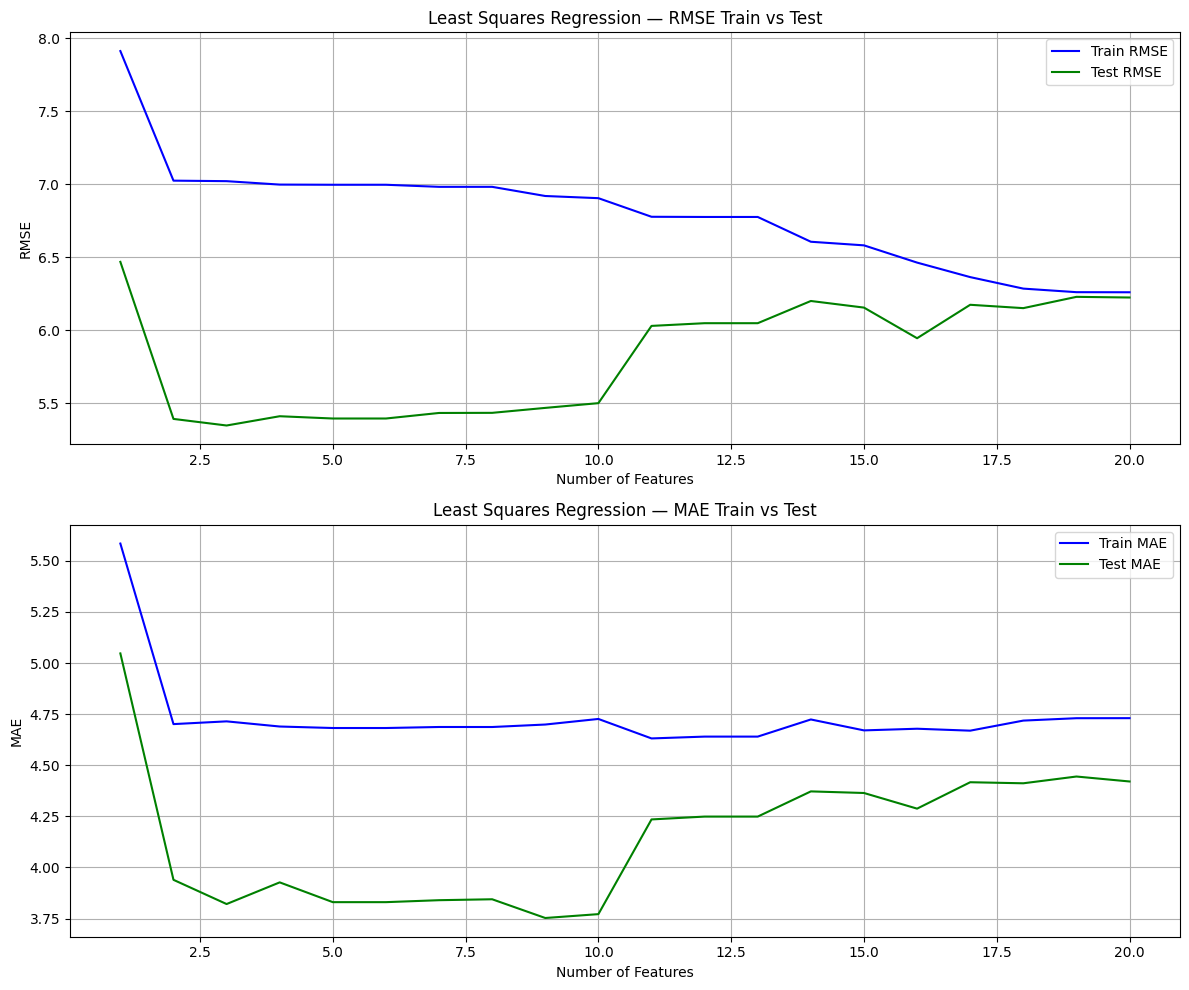

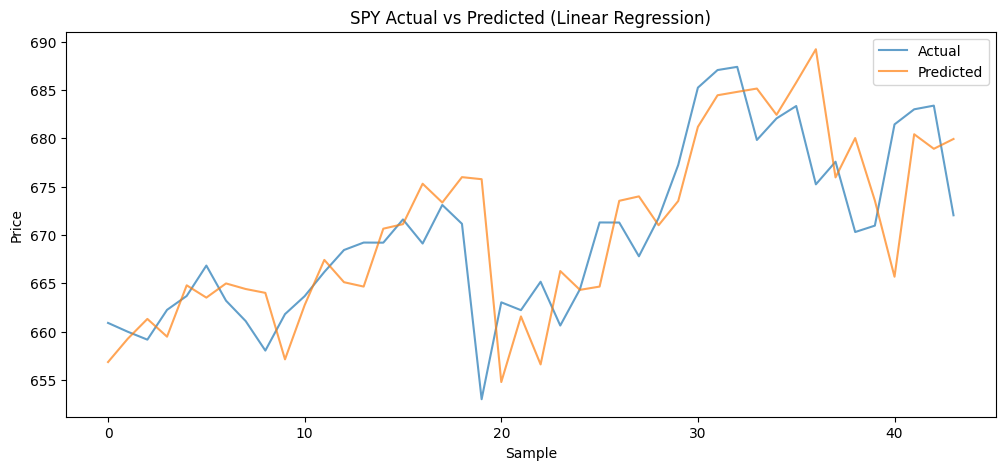

In [57]:
preds = regression_model.predict(X_test)
# Lists to store metrics
rmse_train_list = []
rmse_test_list = []
mae_train_list = []
mae_test_list = []

# Range of features
min_features = 1
num_features = len(col_name)

# Sweep feature count
for k in range(min_features, num_features + 1):

    # First k features only
    X_train_k = X_train.iloc[:, :k]
    X_test_k = X_test.iloc[:, :k]

    model = LinearRegression()
    model.fit(X_train_k, y_train)

    # Predictions
    pred_train = model.predict(X_train_k)
    pred_test = model.predict(X_test_k)

    # RMSE
    rmse_train = np.sqrt(mean_squared_error(y_train, pred_train))
    rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))

    # MAE
    mae_train = mean_absolute_error(y_train, pred_train)
    mae_test = mean_absolute_error(y_test, pred_test)

    # Store
    rmse_train_list.append(rmse_train)
    rmse_test_list.append(rmse_test)
    mae_train_list.append(mae_train)
    mae_test_list.append(mae_test)

# Predict next-day price
latest_row = X.iloc[-1:].copy()
next_close_prediction = regression_model.predict(latest_row)[0]
print(f"\nPredicted Next-Day SPY Close (2025-11-13): {next_close_prediction:.2f}")


# -------------------------------------------------------------
# Plotting (RMSE top subplot, MAE bottom subplot)
# -------------------------------------------------------------
plt.figure(figsize=(12, 10))

# RMSE graph
plt.subplot(2, 1, 1)
plt.plot(range(min_features, num_features + 1), rmse_train_list, label='Train RMSE', color='blue')
plt.plot(range(min_features, num_features + 1), rmse_test_list, label='Test RMSE', color='green')
plt.title("Least Squares Regression — RMSE Train vs Test")
plt.xlabel("Number of Features")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()

# MAE graph
plt.subplot(2, 1, 2)
plt.plot(range(min_features, num_features + 1), mae_train_list, label='Train MAE', color='blue')
plt.plot(range(min_features, num_features + 1), mae_test_list, label='Test MAE', color='green')
plt.title("Least Squares Regression — MAE Train vs Test")
plt.xlabel("Number of Features")
plt.ylabel("MAE")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Plotting the actual value vs the predicted value
plt.figure(figsize=(12,5))
plt.plot(y_test.values, label='Actual', alpha=0.7)
plt.plot(preds, label='Predicted', alpha=0.7)
plt.title("SPY Actual vs Predicted (Linear Regression)")
plt.xlabel("Sample")
plt.ylabel("Price")
plt.legend()
plt.show()

The next model we are using is the Gradient Boosting Regressor.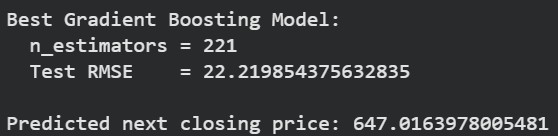

As shown by the picture above (or if you ran the code) the RSME is 22.21 which is way higher then the regression model of 6.22. Also the predicted close price was 647.01 and the actual closing price was 6.71.93 (for the SPY 2025-11-14). So it seems the GBR did much worst than the linear regression model. This is due to that GBR trys to learn nonlinear patterns but the stock-market tends to be more linear. Hence the GBR did much worst. Which came as a suprise for me. I thought GBR would do much better but it does make sense if you look at the over arching shape of the market it goes or down typically(linearly).

In [55]:
# Lists to store RMSE values
rmse_train_list = []
rmse_test_list = []

# List of n_estimators to try
poss_num_estimators = list(range(1, 402, 10))

best_rmse = float('inf')
best_model = None
best_n = None

for n in poss_num_estimators:

    model = GradientBoostingRegressor(
        n_estimators=n,
        learning_rate=0.1,
        random_state=2
    )

    model.fit(X_train, y_train)

    # RMSE
    train_rmse = np.sqrt(np.mean((y_train - model.predict(X_train))**2))
    test_rmse = np.sqrt(np.mean((y_test - model.predict(X_test))**2))

    rmse_train_list.append(train_rmse)
    rmse_test_list.append(test_rmse)

    # Track best model
    if test_rmse < best_rmse:
        best_rmse = test_rmse
        best_model = model
        best_n = n

print("\nBest Gradient Boosting Model:")
print("  n_estimators =", best_n)
print("  Test RMSE    =", best_rmse)

# --- Predict NEXT DAY closing price ---

# X should be your full input dataframe (before splitting)
X_last = X.iloc[-1].values.reshape(1, -1)

next_close = best_model.predict(X_last)[0]
print("\nPredicted next closing price:", next_close)


Best Gradient Boosting Model:
  n_estimators = 221
  Test RMSE    = 22.219854375632835

Predicted next closing price: 647.0163978005481


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Before moving forward I tried tunning the model by using grid search.

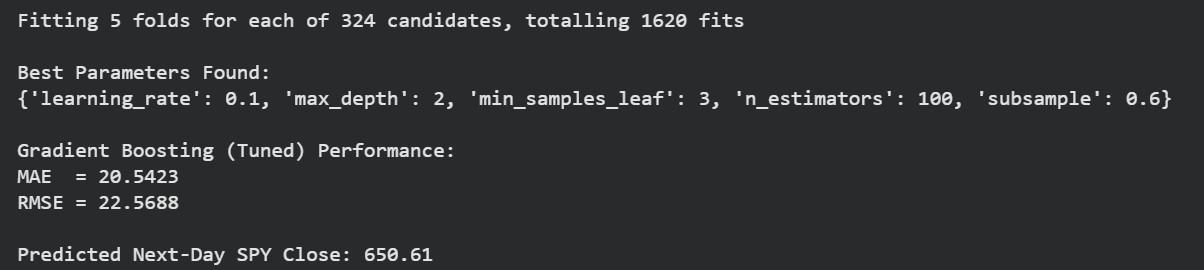

This time around it did perfrom better but again compared to the linear model, it did not come close to it.

In [47]:
# prepare the time-series split

tscv = TimeSeriesSplit(n_splits=5)

# define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [2, 3, 4],
    'subsample': [0.6, 0.8, 1.0],
    'min_samples_leaf': [1, 3, 5]
}

# create the model
gb = GradientBoostingRegressor(random_state=42)

# grid Search with TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=gb,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train.values.ravel())

# best model
best_gb = grid_search.best_estimator_
print("\nBest Parameters Found:")
print(grid_search.best_params_)

# evaluate on test set

preds = best_gb.predict(X_test)

mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))

print("\nGradient Boosting (Tuned) Performance:")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")

# predict tomorrow's closing price
next_close_pred = best_gb.predict(X.iloc[-1:].copy())[0]
print(f"\nPredicted Next-Day SPY Close: {next_close_pred:.2f}")


Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Best Parameters Found:
{'learning_rate': 0.1, 'max_depth': 2, 'min_samples_leaf': 3, 'n_estimators': 100, 'subsample': 0.6}

Gradient Boosting (Tuned) Performance:
MAE  = 20.5423
RMSE = 22.5688

Predicted Next-Day SPY Close: 650.61
